The two most common types of recommender systems are **Content-Based** and **Collaborative Filtering (CF)**. 
- Collaborative filtering produces recommendations based on the knowledge of users' attitude to items, that is it uses the "wisdom of the crowd" to recommend items. 
- Content-based recommender systems focus on the attributes of the items and give you recommendations based on the similarity between them. 

In general, CF is more commonly used than content-based systems because it usually gives better results and is relatively easy to understand (from an overall implementation perspective). The algorithm has the ability to do feature learning on its own, which means that is can start to learn for itself what features to use. 

CF can be divided into **Memory-Based Collaborative Filtering** and **Model-Based Collaborative Filtering**. In the advanced notebook tutorial, we implement Model-Based CF by using singular value decomposition (SVD) and Memory-Based CF by computing cosine similarity. 

For this lesson, we will create a content based recommender system for a data set of movies. This movie data set is usually a student's first data set when beginning to learn about recommender systems. It is quite large compared to some of the other data sets we have worked with, but in general, recommender systems in real life usually deal with much larger data sets than this one. 

In [1]:
import numpy as np
import pandas as pd

In [2]:
columns_names = ['user_id', 'item_id', 'rating', 'timestamp']

In [3]:
df = pd.read_csv('u.data', sep='\t', names=columns_names)

- user_id is the id of the user
- item_id is the id of the item
- rating is the rating the user gave to the item (movie)
- timestamp is when the user gave that movie the rating

In [6]:
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [7]:
movie_titles = pd.read_csv('Movie_Id_Titles')

In [8]:
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


We want to at least merge the two dataframes so that we can connect the item_id with the titles. 

In [9]:
df = pd.merge(df, movie_titles, on='item_id')

Now we have the relavent movie title names in the same row as the item_id. 

In [10]:
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

We are going to create a ratings dataframe with average ratings and number of ratings. 

In [19]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

Let's see the movies with the most ratings. 

In [20]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

Now let's put all of this into a dataframe

In [21]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())

In [22]:
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


Now we have a dataframe where the index is the movie title and the column is the average rating. 

We saw though that a movie may have a very small number of ratings. Having a movie that is rated a 5 isn't really helpful if only one person rated it. So we are going to add a 'number of ratings' column to our ratings dataframe. 

In [23]:
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())

In [24]:
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


Now let's explore this by doing a couple of histograms

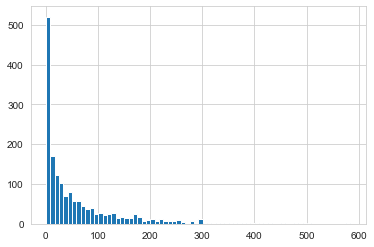

In [25]:
ratings['num of ratings'].hist(bins=70)

We see that most of our movies actually have very little number of ratings. 

Now let's the ratings themself. 

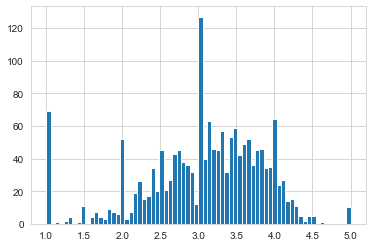

In [26]:
ratings['rating'].hist(bins=70)

Another piece of information we may be interested in is the relationship between the number of ratings and the average rating.

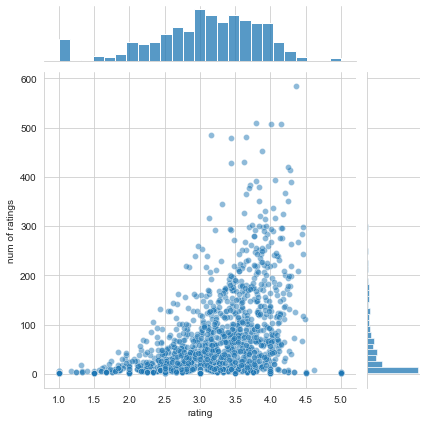

In [27]:
sns.jointplot(x='rating', y='num of ratings', data=ratings, alpha=0.5)

So it seems that that more ratings you get, the more likely you are going to have a higher rated movie. This makes sense as more people will go see more popular movies. 

Now that we known what the data looks like, we are going to build a Recommender System based of item similarity. 

We are going to start by creating a matrix that has the user ID's on one axis and the movie titles on another. Each cell will consist of the rating that the user gave to that movie. 

We are going to use a pivot table to get our original dataframe (df) into matrix form. 

In [28]:
moviemat = df.pivot_table(index='user_id', columns='title', values='rating')

In [29]:
moviemat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


You will notive that we have a lot of missing values, which makes sense because most of the people have not seen most of the movies. 

We are going to grab the user ratings for two movies: Star Wars (1977) and Liar Liar (1997). 

In [30]:
starwars_user_ratings = moviemat['Star Wars (1977)']
liarliar_user_ratings = moviemat['Liar Liar (1997)']

We now have two series of data, one for star wars and one for liar liar with the user id and the rating that they gave the movie. 

In [31]:
starwars_user_ratings.head()

user_id
0    5.0
1    5.0
2    5.0
3    NaN
4    5.0
Name: Star Wars (1977), dtype: float64

We can find the correlation using corrwith, which is similar to corr. Corrwith computes the pairwise correlation between rows or columns of two dataframe objects instead of just the index/columns of a single dataframe

What the line of code below does is give us the correlation between every other movie to the users' behavior to starwars. 

Said another way... 

We took the movie matrix with all the ratings, and with corrwith, we asked, well, how correlated are all these movies and their ratings to the starwars ratings?

In [32]:
similar_to_starwars = moviemat.corrwith(starwars_user_ratings)

C:\Users\Jared\anaconda3\lib\site-packages\numpy\lib\function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\Jared\anaconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [33]:
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)

What we are going to do now is clean this up by removing the null values and make it into a dataframe instead of a series so that it is a little cleaner. 

In [34]:
corr_starwars = pd.DataFrame(similar_to_starwars, columns=['Correlation'])
corr_starwars.dropna(inplace=True)

In [35]:
corr_starwars.head()

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


The Correlation column tells us how correlated that specific movie's ratings where to the starwars ratings. So if we sort the dataframe by correlation, we can find the most similar movies, but we may get some results that don't make sense. 

In [36]:
corr_starwars.sort_values('Correlation', ascending=False).head(10)

,Correlation
title,
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Man of the Year (1995),1.0
Hollow Reed (1996),1.0
"Beans of Egypt, Maine, The (1994)",1.0
"Good Man in Africa, A (1994)",1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0


Notice how a lot of these movies that we really never heard of are perfectly correlated with Star Wars. This happened because these movies have only been seen by one person who also happened to see and rate Starwars with the same rating. We can fix this by filtering out movies that have less than a certain amount of ratings. Where the cutoff is a little subjective, but should be based on the shape of the data. We are going to filter out movies that have less than 100 ratings. 

In [37]:
corr_starwars = corr_starwars.join(ratings['num of ratings'])

In [38]:
corr_starwars.head()

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


Now we are going to filter out any movies that do not have at least 100 ratings. 

In [39]:
corr_starwars[corr_starwars['num of ratings']>100].sort_values('Correlation', ascending=False).head()

,Correlation,num of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130


These correlations make a lot more sense. The reason that Austin Powers might be on here is because it was a really popular movie, and in recommender systems, popular movies tend to get seen by a lot of people, so they get recommended. Now lets repeat with Liar Liar. 

In [45]:
corr_liarliar = pd.DataFrame(similar_to_liarliar, columns=['Correlation'])

In [46]:
corr_liarliar.dropna(inplace=True)

In [47]:
corr_liarliar = corr_liarliar.join(ratings['num of ratings'])

In [48]:
corr_liarliar[corr_liarliar['num of ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137
